#Project 3<br>
LEO Wyndor Model Comparison between SLP (EAE/SAA) and Deterministic Forecast LP Models

Notes:
1. Please use the dataset from the LEO-Wyndor cOre page or the ishaanv/ISLR-Auto dataset from the ishaanv Kaggle repository. 
2.   To make model comparisons we compare using 95% 
MSVAE CI and Generalization Error computation.
4. Use the Q-Q plot & chi-square error tests to identify outliers to be removed.



In [ ]:
!pip install -q pyomo

In [ ]:
!apt-get install -y -qq glpk-utils

In [ ]:
import numpy as np
import random
import pyomo as pyo
import pyomo.gdp as gdp
from pyomo.environ import *
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, kruskal, chisquare, chi2_contingency, ttest_ind, f_oneway
from itertools import tee
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.compat import lzip
%matplotlib inline

Please use the correct LEO-Wyndor dataset as used in the paper, which may be obtained from here: https://core.isrd.isi.edu/id/1/W1R0. Alternately, the correct Wyndor Advertising dataset is available from https://www.kaggle.com/ishaanv/ISLR-Auto.
<br><br>**Note:** the dataset from https://www.kaggle.com/ashydv/advertising-dataset?select=advertising.csv is incorrect and results in regression values that are discrepant from the LEO-Wyndor paper example. 

In [ ]:
#load Advertising csv dataset from your local folder
from google.colab import files
data_to_load = files.upload()

Saving Advertising1.csv to Advertising1.csv


In [ ]:
data = pd.read_csv('Advertising1.csv',index_col=0)
#data.drop("Unnamed: 0",axis=1)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


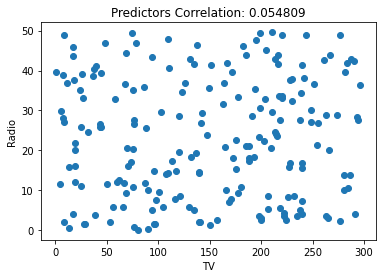

In [ ]:
#check for collinearity among the predictors
#print('correlation between TV and Radio predictors: ',np.corrcoef(data.Radio,data.TV)[0][1])
k=np.corrcoef(data.Radio,data.TV)[0][1]
plt.scatter(data.TV, data.Radio)
plt.xlabel('TV')
plt.ylabel('Radio')
plt.title('Predictors Correlation: %f' %k.item());

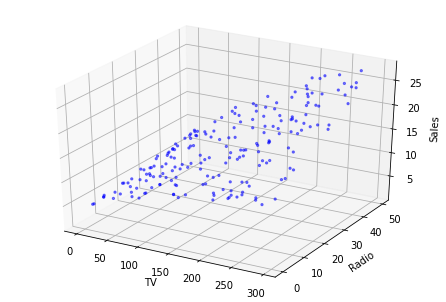

In [ ]:
#visualize the data to ensure it lies on a linear manifold
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data['TV'],data['Radio'],data['Sales'],c = 'b',marker ='.',alpha = 0.5)
ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
plt.show();

#### LEO-Wyndor Workflow Stage 1. SL -  Multiple Linear Regression



In [ ]:
#split data in half to train and test aka validation sets
X = data.iloc[:,:2] #x1, x2
y = data.iloc[:,3] # sales aka omegas
#split data in half so that N = 100 for train and test.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5,random_state=1) 
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)#omit random_state?

In [ ]:
#compute bounds on training set
x1_bounds = (min(X_train.iloc[:,0]),max(X_train.iloc[:,0]))
x2_bounds = (min(X_train.iloc[:,1]), max(X_train.iloc[:,1]))
bounds = [x1_bounds,x2_bounds]
print('x1 bounds:', bounds[0])
print('x2 bounds:', bounds[1])
#notes: [L1,U1] = [0.7,296.4], [L2,U2] = [0,49.6]

x1 bounds: (0.7, 296.4)
x2 bounds: (1.3, 49.4)


In [ ]:
#fit initial regression model on training set, to compute errors and identify outliers
reg1 = LinearRegression().fit(X_train,y_train)

In [ ]:
B0 = reg1.intercept_
B1, B2 = reg1.coef_[0],reg1.coef_[1]
print('B0:',reg1.intercept_)
print('B1:',reg1.coef_[0])
print('B2:',reg1.coef_[1])
#notes B0 = 3.147, B1 = 0.046, B2 = 0.184

B0: 3.124857928852146
B1: 0.044751553149986065
B2: 0.18525853949541002


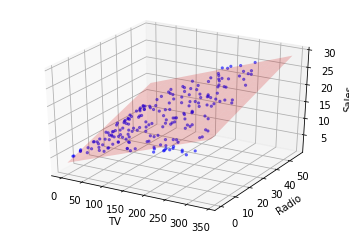

In [ ]:
#Visualize Initial Regression Hyperplane
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(data['TV'],data['Radio'],data['Sales'],c='b',marker='.',alpha = 0.5)
x_surf = np.arange(0,350,20)
y_surf = np.arange(0,60,4)
xx,yy = np.meshgrid(x_surf,y_surf)

exog = pd.core.frame.DataFrame({'TV':xx.ravel(),'Radio':yy.ravel()})
out = reg1.predict(exog)
ax.plot_surface(xx, yy, np.asarray(out).reshape(xx.shape), rstride=1,cstride=1,color='r',alpha=0.2)

ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
plt.show();

### Error analysis, outlier removal, Data Curation & Cleaning, Regression Assumptions check


Compute Errors & Bounds

In [ ]:
e_ti = np.asarray(y_train) - reg1.predict(X_train) #training errors
e_vi = np.asarray(y_test) - reg1.predict(X_test) #validation errors
EAE_ti = B0 + e_ti #Empirical Additive Error array for SP model constraint set 6

In [ ]:
e_ti1 = np.asarray(y_train) - reg1.predict(X_train) #training errors (including train outlier)
e_vi1 = np.asarray(y_test) - reg1.predict(X_test) #val errors (including val outlier)

In [ ]:
chi4err = chisquare(e_ti,e_vi)
chi4err

Power_divergenceResult(statistic=32.62334252437942, pvalue=0.9999999999705097)

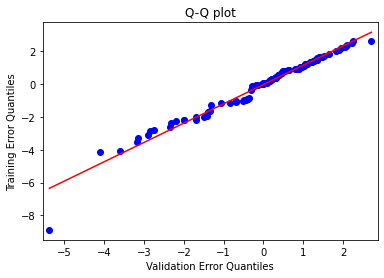

Q-Q plot between e_ti and e_vi


In [ ]:
#QQ plot (using numpy)
e_ti_tiles = np.percentile(e_ti,q=range(0,100)) #returns percentiles of errors in sorted order
e_vi_tiles = np.percentile(e_vi,q=range(0,100))
#m,b = np.polyfit(e_vi_tiles, e_ti_tiles, 1) #qq regression line fitted on errors
#plt.scatter(e_vi_tiles,e_ti_tiles)
#plt.scatter(e_vi_tiles,e_ti_tiles, marker='+',c = 'b',alpha = 0.6)
#plt.plot(e_vi_tiles,m*(e_vi_tiles)+b, color = 'red',ls='-.')
#plt.xlabel('Validation Error Quantiles')
#plt.ylabel('Training Error Quantiles')
#plt.title('Q-Q plot')
#plt.show();

#Q-Q Plot to identify outliers (Using statsmodels)
_, ax = plt.subplots(1,1)
pp_ti = sm.ProbPlot(e_ti)
pp_vi = sm.ProbPlot(e_vi)
##line = '45', 'r', or 'q' for 45 deg, regression line, or quartile line fit
qqplot_2samples(pp_ti, pp_vi, line='r',xlabel='Validation Error Quantiles', ylabel='Training Error Quantiles',ax=ax)
ax.set_title('Q-Q plot')
ax.set_alpha(0.1)
ax.plot(marker='+')
plt.show();
print('Q-Q plot between e_ti and e_vi')

In [ ]:
#get coordinates of outlier from the Q-Q plot
print('coordinates of outlier:\n')
print('(training err, test err)',(e_ti_tiles[0],e_vi_tiles[0]))
#np.where((np.percentile(e_ti,e_ti_tiles[0])))
print('corresponding training row of outlier:',np.where(e_ti == e_ti_tiles[0])[0].item())
print('corresponding test row of outlier:',np.where(e_vi==e_vi_tiles[0])[0].item())

coordinates of outlier:

(training err, test err) (-8.892422180075373, -5.373339022582573)
corresponding training row of outlier: 17
corresponding test row of outlier: 65


In [ ]:
#Remove the outliers row from the training dataset
X_train = np.delete(np.asarray(X_train),[17],axis=0)
y_train = np.delete(np.asarray(y_train),[17])
#Remove the corresponding outlier row from the validation  set
y_test = np.delete(np.asarray(y_test),[65])
X_test = np.delete(np.asarray(X_test),[65],axis=0)

In [ ]:
#refit the regression on training set without outliers
reg1 = LinearRegression().fit(X_train,y_train)

In [ ]:
#new regression coefficients (sans outliers) to be used in the EAE model constraint
B0 = reg1.intercept_
B1, B2 = reg1.coef_[0],reg1.coef_[1]
print('B0:',reg1.intercept_)
print('B1:',reg1.coef_[0])
print('B2:',reg1.coef_[1])

#test with hardcoded values from paper
#B0 = 3.147
#B1 = 0.046
#B2 = 0.184

B0: 3.3217391811627994
B1: 0.04290217205785403
B2: 0.19232714868586656


In [ ]:
e_ti = np.asarray(y_train) - reg1.predict(X_train) #training errors
e_vi = np.asarray(y_test) - reg1.predict(X_test) #test errors
EAE_ti = B0 + e_ti

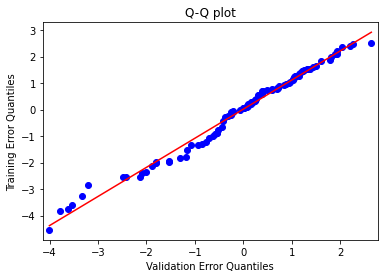

Q-Q plot between e_ti and e_vi


In [ ]:
#QQ plot using numpy
#e_ti_tiles = np.percentile(e_ti,q=range(0,len(e_ti))) #returns percentiles of errors in sorted order
#e_vi_tiles = np.percentile(e_vi,q=range(0,len(e_vi)))
#m,b = np.polyfit(e_vi_tiles, e_ti_tiles, 1) #qq regression line fitted on errors
######plt.scatter(e_vi_tiles,e_ti_tiles)
#plt.scatter(e_vi_tiles,e_ti_tiles, marker='+',c = 'b',alpha = 0.6)
#plt.plot(e_vi_tiles,m*(e_vi_tiles)+b, color = 'red')
#plt.xlabel('Validation Error Quantiles')
#plt.ylabel('Training Error Quantiles')
#plt.title('Q-Q plot');

#new Q-Q plot without outliers
_, ax = plt.subplots(1,1)
pp_ti = sm.ProbPlot(e_ti)
pp_vi = sm.ProbPlot(e_vi)
#line = '45', 'r', or 'q' for 45 deg, regression line, or quartile line fit
qqplot_2samples(pp_ti, pp_vi, line='r',xlabel='Validation Error Quantiles', ylabel='Training Error Quantiles',ax=ax)
ax.set_title('Q-Q plot')
#ax.set_alpha(0.1)
#ax.plot(marker='+')
plt.show();
print('Q-Q plot between e_ti and e_vi')

In [ ]:
chi4err_postout = chisquare(e_ti,e_vi)
chi4err_postout

Power_divergenceResult(statistic=209.44620799879533, pvalue=4.4431143191759067e-10)

## Statistical Learning Stage Model Validation
Validate the regression model by comparing the distribution of errors and coputing the R-squared value.

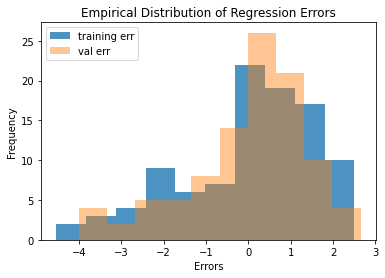

Training and Validation Errors are visually confirmed to be similarly distributed


In [ ]:
buckets = 10
plt.hist(e_ti, label='training err', alpha = 0.8,bins=buckets)
plt.hist(e_vi,label='val err', alpha=0.45,bins=buckets)
plt.xlabel('Errors')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.title('Empirical Distribution of Regression Errors')
plt.show();
print('Training and Validation Errors are visually confirmed to be similarly distributed')

In [ ]:
#to verify whether the errors are drawn from the same distribution
obs = np.concatenate((e_ti**2,e_vi**2)) #use squared errors since obs must be positive valued for chi2_contingency
h = chi2_contingency(obs)
test_stat = h[0]
print('test statistic h:',test_stat)
#test statistic is zero, so we accept the null hypothesis that the errors are from the same distribution

test statistic h: 0.0


In [ ]:
from sklearn.metrics import r2_score

In [ ]:
#Validate Statistical Learning stage by computing R2 for Regression on the validation set
R2 = r2_score(y_test,reg1.predict(X_test))

In [ ]:
print('Validation set R-squared for the regression model is:', R2)

Validation set R-squared for the regression model is: 0.9232449155593827


Since we have a high R2, our regression model is validated on the test data.

In [ ]:
#X_arr = np.asarray(X)
#y_arr = np.asarray(y)
#regH = LinearRegression().fit(X_arr,y_arr)
#B0h = regH.intercept_
#B1h, B2h = regH.coef_
#print('B0h',B0h)
#print('B1h',B1h)
#print('B2h',B2h)

### Check Conditional Mean of Errors is centered at zero

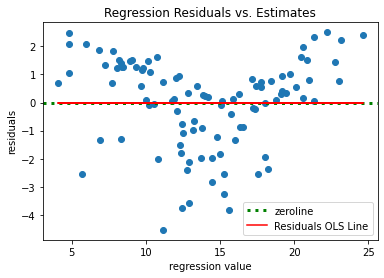

Resdiduals regression slope: -1.989147227960705e-16
since the residuals regression overlaps the zeroline, assumption of conditional errors with mean zero is satisfied.
therefore, regression estimates are unbiased.


In [ ]:
#verify that the conditional errors are centered at mean zero. Unbiased residuals assumption 
train_hats = reg1.predict(X_train)
b,m = np.polyfit(train_hats, e_ti,1)
#poly1dfcn = np.poly1d([b,m])
plt.scatter(train_hats,e_ti)
plt.axhline(y=0,label='zeroline',color='g',linewidth='3',linestyle=':')
plt.plot(train_hats,b+m*(train_hats),color = 'r',linestyle='-',label='Residuals OLS Line')
#plt.errorbar(train_hats, poly1dfcn(train_hats),yerr=poly1dfcn(train_hats)-e_ti)#, fmt='.k')
plt.legend(loc='lower right')
plt.xlabel('regression value')
plt.ylabel('residuals')
plt.title('Regression Residuals vs. Estimates')
plt.show();
print('Resdiduals regression slope:', b)
print('since the residuals regression overlaps the zeroline, assumption of conditional errors with mean zero is satisfied.')
print('therefore, regression estimates are unbiased.')

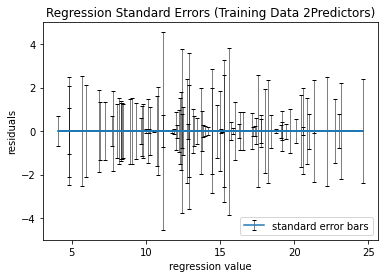

Plot of the standard errors indicates the presence of heteroscedasticity in the training regression.


In [ ]:
#plot standard errors of regression to check for heterscedasticity
train_hats = reg1.predict(X_train)
b,m = np.polyfit(train_hats, e_ti,1)
poly1dfcn = np.poly1d([b,m])
#plt.scatter(train_hats,e_ti)
#plt.axhline(y=0,label='zeroline',color='g',linewidth='3',linestyle=':')
#plt.plot(train_hats,b+m*(train_hats),color = 'r',linestyle='-',label='Residuals OLS Line')
plt.errorbar(train_hats, poly1dfcn(train_hats),yerr=poly1dfcn(train_hats)-e_ti, ecolor='k',\
             ls ='-',elinewidth = 0.5, capsize=2, label='standard error bars')
plt.legend(loc='lower right')
plt.xlabel('regression value')
plt.ylabel('residuals')
plt.title('Regression Standard Errors (Training Data 2Predictors)')
plt.show();
print('Plot of the standard errors indicates the presence of heteroscedasticity in the training regression.')

While the plot is indicative of heterscedasticity which confirms the results of our White-Test that indicate the presence of some non-linear heterscedasticity. In general, we apply the commonly used industry best practice that the heteroscedasticity can be safely disregarded so long as the change in standard errors does not vary by more than a factor of 2 across the regression, which is the case for this regression model. We will return to deal with the heteroscedasticity in a later extension part of the model.

### Omitted Variable Bias
Check that Cov(X, $\epsilon$) = 0.

TV & errors correlation: -1.4579416624880303e-15


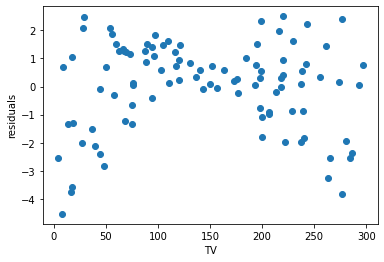

In [ ]:
plt.scatter(X_train[:,0],e_ti)
plt.xlabel('TV')
plt.ylabel('residuals');
print('TV & errors correlation:',np.corrcoef(X_train[:,0],e_ti)[0][1])

Radio & errors correlation: 5.046352595495065e-16


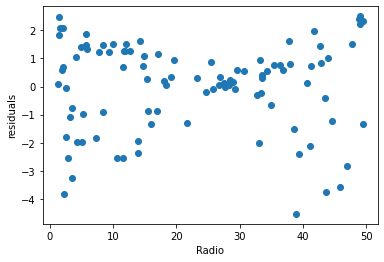

In [ ]:
plt.scatter(X_train[:,1],e_ti)
plt.xlabel('Radio')
plt.ylabel('residuals');
print('Radio & errors correlation:',np.corrcoef(X_train[:,1],e_ti)[0][1])

### Check for auto-correlation of Residuals

In [ ]:
from statsmodels.graphics import tsaplots
from statsmodels.stats.stattools import durbin_watson

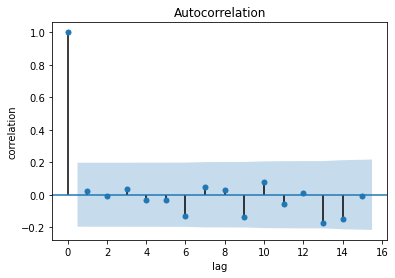

In [ ]:
fig = tsaplots.plot_acf(e_ti,lags=15)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

In [ ]:
#acf plot coefficients are low at all lags up to 15, close to zero, confirming that our data is not auto-correlated

In [ ]:
#DW tests for serial correlation at lag 1
#4 = negative serial correlation, 0 = positive serial correlation, 2 = no serial correlation at all
DW_score = durbin_watson(e_ti,axis=0)
print('Durbin-Watson Stat:', DW_score)
print('since the DW_score is close to 2, little to no serial correlation is present in our data')

Durbin-Watson Stat: 1.8866181094557013
since the DW_score is close to 2, little to no serial correlation is present in our data


A common industry standard practice is to only worry about heteroscedasticity if the standard errors of the residuals are changing by more than a factor of 2 as we vary across regression plane values. For changes less than that, we can generally safely ignore it and proceed as if under the homoscedastic case. (To verify this we check the residual error plots on the all-data-sans-outlier)

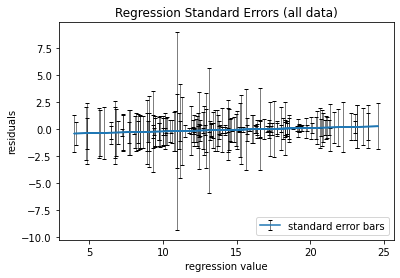

In [ ]:
#verify that the conditional errors are centered at mean zero. Unbiased residuals assumption 
allhats = reg1.predict(X)
e_all = y - allhats
b,m = np.polyfit(allhats, e_all,1)
poly1dfcn = np.poly1d([b,m])
#plt.scatter(train_hats,e_ti)
#plt.axhline(y=0,label='zeroline',color='g',linewidth='3',linestyle=':')
#plt.plot(train_hats,b+m*(train_hats),color = 'r',linestyle='-',label='Residuals OLS Line')
plt.errorbar(allhats, poly1dfcn(allhats),yerr=poly1dfcn(allhats)-e_all, ecolor='k',\
             ls ='-',elinewidth = 0.5, capsize=2, label='standard error bars')
plt.legend(loc='lower right')
plt.xlabel('regression value')
plt.ylabel('residuals')
plt.title('Regression Standard Errors (all data)');
#print('Plot of the standard errors indicates the presence of heteroscedasticity')

In [ ]:
X_noOut = np.delete(np.asarray(X),[130,5,125],axis=0)
y_noOut = np.delete(np.asarray(y), [130,5,125])


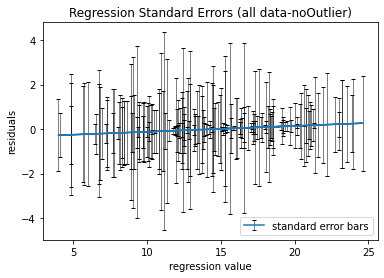

In [ ]:
allhats_noOut = reg1.predict(X_noOut)
e_all_noOut = y_noOut - allhats_noOut
b,m = np.polyfit(allhats_noOut, e_all_noOut,1)
poly1dfcn = np.poly1d([b,m])
#plt.scatter(train_hats,e_ti)
#plt.axhline(y=0,label='zeroline',color='g',linewidth='3',linestyle=':')
#plt.plot(train_hats,b+m*(train_hats),color = 'r',linestyle='-',label='Residuals OLS Line')
plt.errorbar(allhats_noOut, poly1dfcn(allhats_noOut),yerr=poly1dfcn(allhats_noOut)-e_all_noOut, ecolor='k',\
             ls ='-',elinewidth = 0.5, capsize=2, label='standard error bars')
plt.legend(loc='lower right')
plt.xlabel('regression value')
plt.ylabel('residuals')
plt.title('Regression Standard Errors (all data-noOutlier)');
#np.argmax(poly1dfcn(allhats_noOut)-e_all_noOut)

Since the regression heteroscedasticity does not vary by more than a factor of 2 across the values, we proceed *as if* the regression errors were homoscedastic

### Heteroscedasticity Test 1
Here we test the residuals from our training set 2-predictor regression model for heterscedasticity by using the Breusch-pagan and white tests. The breusch-pagan tests for linear heterscedasticity while the white test checks for bias as the result of heteroscedastity by including interaction terms in the regressors. The null hypothesis is that the errors are homoscedastic which we accept if the p-values are larger than 0.05.

In [ ]:
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

In [ ]:
#add intercept column for compatibility with statsmodels
resids = e_ti
ones = np.ones(len(X_train))
exog = np.concatenate((np.array(ones)[:,np.newaxis],X_train),axis=1)

In [ ]:
#breusch-pagan test
bp_test_train = het_breuschpagan(resids, exog)

In [ ]:
keys_bp =['LM stat','LM-Test p-value','F-stat','F-Test p-value']
#print(dict(zip(labels,bp_test)))
lzip(keys_bp,bp_test_train)

[('LM stat', 1.7836204357339391),
 ('LM-Test p-value', 0.4099130488023327),
 ('F-stat', 0.8806518129862361),
 ('F-Test p-value', 0.4178341632510739)]

Since the p-values for the breusch-pagan test are so large, we fail to reject the null hypothesis that there is no linear heteroscedastity in our data.

In [ ]:
#white test (for linear and non-linear forms of heteroscedasticity)
keys = ['Lagrange Multiplier Stat:','LM test\'s p-value','F-stat:','F-test\'s p-value:']
results = het_white(resids, exog)
lzip(keys,results)

[('Lagrange Multiplier Stat:', 56.9613419144024),
 ("LM test's p-value", 5.1505896340068116e-11),
 ('F-stat:', 25.202539944319998),
 ("F-test's p-value:", 5.590381123443981e-16)]

Since the p-values from our White-test for heteroscedasticity are significantly less than 5%, we reject the null hypothesis in favor of the alternative that there is some form of heteroscedasticity. However since the Breusch-Pagan test indicated that there was no linear heteroscedasticity, this suggests that the heteroscedasticity being detected in the training data is non-linear in origin.

In [ ]:
#Residuals from our two variable regression model also pass the breusch-pagan heterscedasticity test since
#p-values for both the LM and F stats are greater than 0.05. So we fail to reject the null that the errors are homoscedastic
#thus we proceed on the assumption that the errors are in fact homoscedastic

### Heteroscedasticity test 2
Here we run the regression on all 3 variables from the dataset and test for heteroscedasticity using the Breusch-Pagan and White tests. All 3 predictors are used so as to avoid effects from ommitted variable bias.

In [ ]:
X_het = np.asarray(data.iloc[:,:3])
y_het = np.asarray(data.iloc[:,3])

In [ ]:
#fit a linear regression on the entire dataset
regHet = LinearRegression().fit(X_het, y_het)

In [ ]:
#collect residuals
e_het = y_het - regHet.predict(X_het)

In [ ]:
#add intercept ones column to the design matrix X_het for compatibility with statsmodels
ones1 = np.ones(len(X_het))
exog1 = np.concatenate((np.array(ones1)[:,np.newaxis],X_het),axis=1)
resids1 = e_het

In [ ]:
#Breusch-pagan test full data residuals, 3 predictors
bp_test = het_breuschpagan(resids1, exog1)
#Breusch-pagan test results
keys_bp =['LM stat','LM-Test p-value','F-stat','F-Test p-value']
lzip(keys_bp,bp_test)

[('LM stat', 5.1328723532856335),
 ('LM-Test p-value', 0.16232215845412137),
 ('F-stat', 1.7209042102915961),
 ('F-Test p-value', 0.16399908905607358)]

In [ ]:
#white-test full data residuals, 3 predictors
keys1 = ['Lagrange Multiplier Stat:','LM test\'s p-value','F-stat:','F-test\'s p-value:']
results1 = het_white(resids1, exog1)
lzip(keys1,results1)

[('Lagrange Multiplier Stat:', 67.53524303975244),
 ("LM test's p-value", 4.623717263735753e-11),
 ('F-stat:', 10.763195075018862),
 ("F-test's p-value:", 1.8829217663480832e-13)]

These results confirm our findings from Heteroscedasticity Test 1 Section.

In [ ]:
#Conditional Errors are centered with mean zero
#print(np.mean(resids1)
#predHet = regHet.predict(X_het)
#plt.scatter(predHet,e_het)

LEO-Wyndor Workflow Stage 2. Stochastic Linear Programming

SLP with SAA (Empirical Additive Errors)

In [ ]:
#Compute the EAE_ti for the SLP model constraint 6: non-deterministic regression
EAE_ti = B0 + e_ti

In [ ]:
len(EAE_ti)

99

In [ ]:
#np.random.RandomState(seed=0)
#declare model
N = len(EAE_ti) #minus 1 outliers #N should be = len(EAE_ti)
m = ConcreteModel()
m.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m.yA = Var(m.IDX,domain=NonNegativeReals)
m.yB = Var(m.IDX,domain=NonNegativeReals)

#declare objective
m.OBJ = Objective(expr= -0.1*m.x[1]-0.5*m.x[2]+(1/N)*(sum(3*m.yA[i]+5*m.yB[i] for i in m.IDX)),sense=maximize)

#declare constraints
m.Constraint1 = Constraint(expr=m.x[1]+m.x[2]<=200)
m.Constraint2 = Constraint(expr=m.x[1]-0.5*m.x[2]>=0)

def c3_rule(m,i):
    return m.yA[i]<=8
m.Constraint3 = Constraint(m.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m.yB[i] <=12
m.Constraint4 = Constraint(m.IDX,rule=c4_rule)

def c5_rule(m,i):
    return 3*m.yA[i]+2*m.yB[i]<=36
m.Constraint5 = Constraint(m.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= EAE_ti[i-1] #EAE_ti = B0 + e_ti (array of training errors)
    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= np.random.choice(EAE_ti)
m.Constraint6 = Constraint(m.IDX, rule=c6_rule)

#solve the SLP with SAA model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m)

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.5199443914113, 'Upper bound': 40.5199443914113, 'Number of objectives': 1, 'Number of constraints': 399, 'Number of variables': 201, 'Number of nonzeros': 797, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.022184133529663086}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
x1hat = m.x.extract_values()[1]
x2hat = m.x.extract_values()[2]
objvalue = m.OBJ.expr()
print('SLP optimal x1:', x1hat)
print('SLP optimal x2:', x2hat)
print('SLP Estimated Obj.', objvalue)

SLP optimal x1: 182.756196059082
SLP optimal x2: 17.2438039409181
SLP Estimated Obj. 40.51994439141123


Deterministic LP Model

In [ ]:
#Deterministic model
N = 1
m2 = ConcreteModel()
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m2.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)
m2.IDX = RangeSet(1,N)
m2.yA = Var(m2.IDX,domain=NonNegativeReals)
m2.yB = Var(m2.IDX,domain=NonNegativeReals)

#declare objective
m2.OBJ = Objective(expr= -0.1*m2.x[1]-0.5*m2.x[2]+(1/N)*(sum(3*m2.yA[i]+5*m2.yB[i] for i in m2.IDX)),sense=maximize)

#declare constraints
m2.Constraint1 = Constraint(expr=m2.x[1]+m2.x[2]<=200)
m2.Constraint2 = Constraint(expr=m2.x[1]-0.5*m2.x[2]>=0)

def c3_rule(m,i):
    return m2.yA[i]<=8
m2.Constraint3 = Constraint(m2.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m2.yB[i]<=12
m2.Constraint4 = Constraint(m2.IDX,rule=c4_rule)

def c5_rule(m,i):
    return 3*m2.yA[i]+2*m2.yB[i]<=36
m2.Constraint5 = Constraint(m2.IDX,rule=c5_rule)

def c6_rule(m,i):
    return -B1*m2.x[1] - B2*m2.x[2]+m2.yA[i]+m2.yB[i] <= B0
m2.Constraint6 = Constraint(m2.IDX, rule=c6_rule)

opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m2)

{'Problem': [{'Name': 'unknown', 'Lower bound': 41.0304111140194, 'Upper bound': 41.0304111140194, 'Number of objectives': 1, 'Number of constraints': 7, 'Number of variables': 5, 'Number of nonzeros': 13, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.0169827938079834}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
detx1 = m2.x.extract_values()[1]
detx2 = m2.x.extract_values()[2]
print('deterministic optimal x1:', m2.x.extract_values()[1])
print('deterministic optimal x2:', m2.x.extract_values()[2])
print('deterministic Obj.', m2.OBJ.expr())

deterministic optimal x1: 172.576027785048
deterministic optimal x2: 27.4239722149516
deterministic Obj. 41.0304111140194


LEO-Wyndor Workflow Stage 3. Validation

MVSAE (Model Validation Sample Average Estimate).<br>
a 95% CI of the Sample Average of the SLP using errors from the validation set

In [ ]:
#solve the SLP model for MSVAE Confidence Interval using fixed decision and a randomly sampled validation error
def SLP_val_solve(x1,x2, val_err):
  N = 1
  m = ConcreteModel()
  m.IDX = RangeSet(1,N)
  #declare variables
  #  def _bounds_rule(m,i):
  #      return bounds[i-1]
  #  m.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

  m.yA = Var(m.IDX,domain=NonNegativeReals)
  m.yB = Var(m.IDX,domain=NonNegativeReals)

  #declare objective
  m.OBJ = Objective(expr= -0.1*x1-0.5*x2+(1/N)*(sum(3*m.yA[i]+5*m.yB[i] for i in m.IDX)),sense=maximize)

  #no x-constraints since we are validating the fixed x decisions from the previous model.
#  #m.Constraint1 = Constraint(expr=x1+x2<=200)
#  #m.Constraint2 = Constraint(expr=x1-0.5*x2>=0)

  def c3_rule(m,i):
      return m.yA[i]<=8
  m.Constraint3 = Constraint(m.IDX,rule=c3_rule)

  def c4_rule(m,i):
      return m.yB[i] <=12
  m.Constraint4 = Constraint(m.IDX,rule=c4_rule)

  def c5_rule(m,i):
      return 3*m.yA[i]+2*m.yB[i]<=36
  m.Constraint5 = Constraint(m.IDX,rule=c5_rule)

  def c6_rule(m,i):
      return -B1*x1 - B2*x2+m.yA[i]+m.yB[i] <= B0 + val_err
  m.Constraint6 = Constraint(m.IDX, rule=c6_rule)

  #solve the SLP with SAA model
  opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
  opt.solve(m)
  return m

In [ ]:
# validate the EAE/SAA model decision using M replications sampling from the validation error in each run
x1 = x1hat
x2 = x2hat
valObjs = []
M = 200 #use 200, 500 or 1000 for the point estimate
for reps in range(0,M):
  val_err = np.random.choice(e_vi)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/sqrt(len(valObjs))
print('EAE/SAA model predicted objective', m.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))

EAE/SAA model predicted objective 40.51994439141123
Model Validation Sample Average Estimate (95% CI): (39.65390547658917, 40.82992783608752)


In [ ]:
# validate the Deterministic Regression-LP model decision using M replications sampling from the validation error in each run
x1 = detx1
x2 = detx2
valObjs = []
M = 200 #use 500 or 1000 for point estimate
for reps in range(0,M):
  val_err = np.random.choice(e_vi)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/sqrt(len(valObjs))
print('deterministic regression-LP model predicted objective', m2.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))

deterministic regression-LP model predicted objective 41.0304111140194
Model Validation Sample Average Estimate (95% CI): (38.90550813700923, 39.762909500985465)


Comments on Validity of LP-based model with deterministic regression versus the EAE/SAA model.<br>


In general, we observe that the LP with deterministic regression predicts a more optimistic objective value than the EAE SLP model with (N = 100 trainig error samples). Additionally, the Deterministic forecast falls outside of the validation interval (M = 1000 replications) whereas the EAE/SLP model falls within the 95% validation interval. Therefore, we have more trust in the EAE/SLP prediction that the LP with deterministic regression.

#### This Concludes the minimum requirements of the project. The following are extensions.

In [ ]:
def SLP_gen_sol(N):
  m = ConcreteModel()
  m.IDX = RangeSet(1,N)
  #declare variables
  def _bounds_rule(m,i):
      return bounds[i-1]
  m.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

  m.yA = Var(m.IDX,domain=NonNegativeReals)
  m.yB = Var(m.IDX,domain=NonNegativeReals)

  #declare objective
  m.OBJ = Objective(expr= -0.1*m.x[1]-0.5*m.x[2]+(1/N)*(sum(3*m.yA[i]+5*m.yB[i] for i in m.IDX)),sense=maximize)

  #declare constraints
  m.Constraint1 = Constraint(expr=m.x[1]+m.x[2]<=200)
  m.Constraint2 = Constraint(expr=m.x[1]-0.5*m.x[2]>=0)

  def c3_rule(m,i):
      return m.yA[i]<=8
  m.Constraint3 = Constraint(m.IDX,rule=c3_rule)

  def c4_rule(m,i):
      return m.yB[i] <=12
  m.Constraint4 = Constraint(m.IDX,rule=c4_rule)

  def c5_rule(m,i):
      return 3*m.yA[i]+2*m.yB[i]<=36
  m.Constraint5 = Constraint(m.IDX,rule=c5_rule)

  #np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

  def c6_rule(m,i):
  #    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= EAE_ti[i-1] #EAE_ti = B0 + e_ti (array of training errors in 1-1 correspondance to obs instance)
      return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= np.random.choice(EAE_ti)
  m.Constraint6 = Constraint(m.IDX, rule=c6_rule)

  #solve the SLP with SAA model
  opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
  #opt = SolverFactory('cbc')
  #opt.solve(m,,tee=True)
  opt.solve(m)
  return m

# Extension 1
LEO with Inverse Weighted SAA

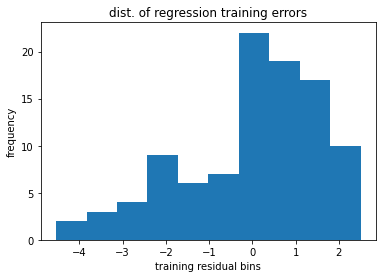

In [ ]:
plt.hist(e_ti)
plt.xlabel('training residual bins')
plt.ylabel('frequency')
plt.title('dist. of regression training errors');

In [ ]:
pdf, bins = np.histogram(e_ti,density=True)

In [ ]:
df1 = pd.DataFrame(e_ti, columns=['train_err'])
mu = e_ti.mean()
sig = e_ti.std()
df1['z'] = stats.mstats.zscore(df1.train_err)
df1['prob']=0.0
for idx, row in df1.iterrows():
  if row.train_err<mu:
    df1.at[idx,'prob'] = (stats.norm(mu,sig).pdf(row.train_err))
  else:
    df1.at[idx,'prob'] = stats.norm(mu,sig).pdf(row.train_err)

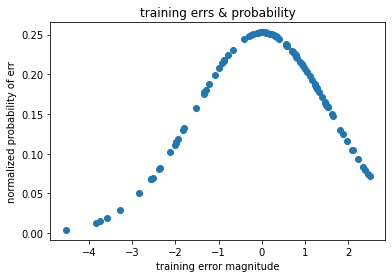

In [ ]:
plt.scatter(df1.train_err,df1.prob)
plt.xlabel('training error magnitude')
plt.ylabel('normalized probability of err')
plt.title('training errs & probability');

In [ ]:
wts = np.asarray(df1.prob)
#normalize the training weights
norm_wts = wts/wts.sum()
sum(norm_wts)

0.9999999999999999

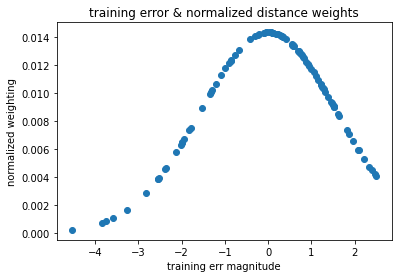

In [ ]:
plt.scatter(df1.train_err,norm_wts)
plt.xlabel('training err magnitude')
plt.ylabel('normalized weighting')
plt.title('training error & normalized distance weights');

In [ ]:
#compute normalized distance based probabilities of validation errors
df2 = pd.DataFrame(e_vi, columns=['val_err'])
mu = e_vi.mean()
sig = e_vi.std()
df2['z'] = stats.mstats.zscore(df2.val_err)
df2['prob']=0.0
for idx, row in df2.iterrows():
  if row.val_err<mu:
    df2.at[idx,'prob'] = (stats.norm(mu,sig).pdf(row.val_err))
  else:
    df2.at[idx,'prob'] = stats.norm(mu,sig).pdf(row.val_err)

In [ ]:
#normalize the validation error probabilities into proper weighting
v_wts = np.asarray(df2.prob)
val_wts = v_wts/v_wts.sum()
#val_wts

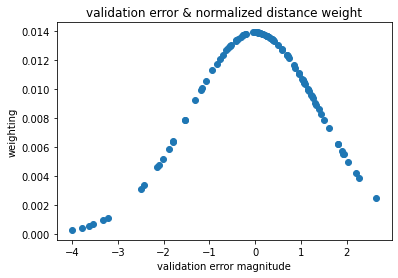

In [ ]:
plt.scatter(df2.val_err,val_wts)
plt.xlabel('validation error magnitude')
plt.ylabel('weighting')
plt.title('validation error & normalized distance weight');

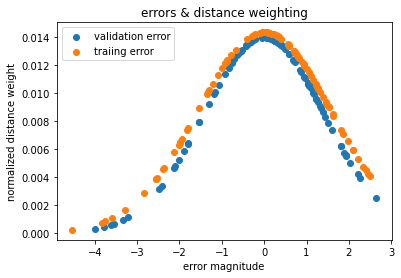

In [ ]:
plt.scatter(df2.val_err,val_wts,label='validation error')
plt.scatter(df1.train_err,norm_wts, label='traiing error')
plt.xlabel('error magnitude')
plt.ylabel('normalized distance weight')
plt.legend()
plt.title('errors & distance weighting');

In [ ]:
#declare Weighted Sample Average model (Distance-based inverse weightings)
N = len(e_ti) #minus 1 outliers
m3 = ConcreteModel()
m3.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m3.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m3.yA = Var(m3.IDX,domain=NonNegativeReals)
m3.yB = Var(m3.IDX,domain=NonNegativeReals)

#declare objective
m3.OBJ = Objective(expr= -0.1*m3.x[1]-0.5*m3.x[2]+(sum(norm_wts[i-1]*(3*m3.yA[i]+5*m3.yB[i]) for i in m3.IDX)),sense=maximize)

#declare constraints
m3.Constraint1 = Constraint(expr=m3.x[1]+m3.x[2]<=200)
m3.Constraint2 = Constraint(expr=m3.x[1]-0.5*m3.x[2]>=0)

def c3_rule(m,i):
    return m3.yA[i]<=8
m3.Constraint3 = Constraint(m3.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m3.yB[i] <=12
m3.Constraint4 = Constraint(m3.IDX,rule=c4_rule)

def c5_rule(m,i):
    return (3*m3.yA[i]+2*m3.yB[i]) <=36
m3.Constraint5 = Constraint(m3.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= EAE_ti[i-1] #EAE_ti = B0 + e_ti (array of training errors)
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(EAE_ti,p=norm_wts)
    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(B0+e_ti,p=norm_wts) #with wts
#     return -B1*m3.x[1] - B2*m3.x[2]+(m3.yA[i]+m3.yB[i]) <= np.random.choice(B0+e_ti) #without wts
m3.Constraint6 = Constraint(m3.IDX, rule=c6_rule)

#solve the SLP with SAA model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m3)

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.8911783069193, 'Upper bound': 40.8911783069193, 'Number of objectives': 1, 'Number of constraints': 399, 'Number of variables': 201, 'Number of nonzeros': 797, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.022229909896850586}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
wt_x1 = m3.x.extract_values()[1]
wt_x2 = m3.x.extract_values()[2]
print('weighted SAA optimal x1:', m3.x.extract_values()[1])
print('weighted SAA optimal x2:', m3.x.extract_values()[2])
print('weighted SAA Obj.', m3.OBJ.expr())

weighted SAA optimal x1: 182.317063347376
weighted SAA optimal x2: 17.682936652624
weighted SAA Obj. 40.891178306919294


In [ ]:
x1 = wt_x1
x2 = wt_x2
valObjs = []
M = 200 #use 500 or 1000 for point estimate
for reps in range(0,M):
  val_err = np.random.choice(e_vi,p=val_wts) #do I need to put val_wts on the other validations? default p= uniform draws
  #val_err = np.random.choice(e_vi)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/sqrt(len(valObjs))
print('weighted avg SLP model predicted objective', m3.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))

weighted avg SLP model predicted objective 40.891178306919294
Model Validation Sample Average Estimate (95% CI): (40.788446625555665, 41.55176115371057)


We observe that the weighted sample average approximation EAE model also manages to produce an MPO result within the MSVAE 95% confidence interval.

# Generalization Error Estimates

Note: In order to compute the generalization error, training and validation sets must be same size sets to compute the covariance over each recourse realization.

In [ ]:
#Recourse Solve
def hSolve(x1,x2,B0,B1,B2,err):
  h = ConcreteModel()
  h.yA = Var(domain=NonNegativeReals)
  h.yB = Var(domain=NonNegativeReals)

  h.OBJ = Objective(expr=3*h.yA+5*h.yB,sense=maximize)

  h.Constraint1 = Constraint(expr = h.yA <= 8)

  h.Constraint2 = Constraint(expr = h.yB <= 12)

  h.Constraint3 = Constraint(expr = 3*h.yA + 2*h.yB <= 36)

  h.Constraint4 = Constraint(expr = h.yA + h.yB <= B0 + B1*x1 + B2*x2 + err)

  #solve model
  opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
  opt.solve(h)

  return h

In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(wt_x1,wt_x2,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(wt_x1,wt_x2,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())

hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar value profits in validation and training and average them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
WSAA_generr = sum(temp)*(2/len(hts))
print('EAE/WSAA Generalization Error: ',WSAA_generr)

EAE/WSAA Generalization Error:  -1.3865086884848896


In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(x1hat,x2hat,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(x1hat,x2hat,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())

hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i]for i in range(len(hts))]
SAA_generr = sum(temp)*(2/len(hts))
print('EAE/SAA Generalization Error: ',SAA_generr)

EAE/SAA Generalization Error:  -1.4594761064117636


In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(detx1,detx2,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(detx1,detx2,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())

hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
det_generr = sum(temp)*(2/len(hts))
print('deterministic Generalization Error: ',det_generr)

deterministic Generalization Error:  -0.06341372585644191


In [ ]:
print('deterministic Generalization Error: ',det_generr)
print('EAE/WSAA Generalization Error: ',WSAA_generr)
print('EAE/SAA Generalization Error: ',SAA_generr)

deterministic Generalization Error:  -0.06341372585644191
EAE/WSAA Generalization Error:  -1.3865086884848896
EAE/SAA Generalization Error:  -1.4594761064117636


The model with the greatest generalization error is the worst performing, while the model with the least generalization error is best.

# Extension 2
Leverage-Signal based EAE/WSAA

Create an overfitted regression on the full dataset 

In [ ]:
X_new = np.append(X_train,X_test,axis=0)
y_new = np.append(y_train,y_test,axis=0)

In [ ]:
#X_arr = np.asarray(X)
#y_arr = np.asarray(y)
X_arr = X_new
y_arr = y_new
regH = LinearRegression().fit(X_arr,y_arr)
B0h = regH.intercept_
B1h, B2h = regH.coef_
print('B0h',B0h)
print('B1h',B1h)
print('B2h',B2h)

B0h 3.0519084406471695
B1h 0.04422034399953621
B2h 0.19529474694369234


Append a vector of ones to the design matrix of predictor data to account for intercept coefficient and compute the projection matrix of the overfitted model. 

In [ ]:
ones = np.ones(len(X_arr))
X_try = np.concatenate((np.array(ones)[:,np.newaxis],X_arr),axis=1)
#projection matrix H
H = np.matmul(np.matmul(X_try,np.linalg.inv(np.matmul(X_try.T,X_try))),X_try.T)

In [ ]:
#for more generalized regression models we should ideally use the covariance of residuals in
#computing our projection matrix
#incorporating the covariance matrix of residuals: psi. psi should be 198 x 198
#psi = np.cov(e_ti1.T,e_vi1.T)
#psi

Extract leverages from the diagonal of the overfitted model's projection matrix.

In [ ]:
levs = np.diag(H,k=0) #extract all leverage scores from the diagonal of the projection matrix
train_levs = levs[:99] #first 99 will correspond to the training set's leverages
val_levs = levs[99:] #latter half are leverage scores for the validation points

In [ ]:
#compute a threshold value p/N which serves to represent an idealized regresison where all points
#contribute equally to the regression plane slope.
p = sum(levs) #equals the number of predictors
N = len(H) #Number of observations
thresh = p/N

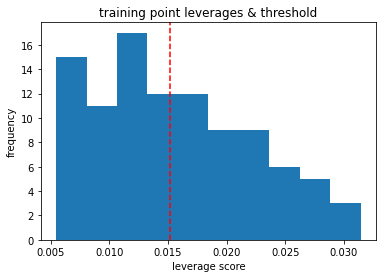

In [ ]:
plt.hist(train_levs);
plt.axvline(x = thresh,color='r',linestyle='--')
plt.xlabel('leverage score')
plt.ylabel('frequency')
plt.title('training point leverages & threshold');
#leverages below the threshold can be down weighted, while those above can be upweighted

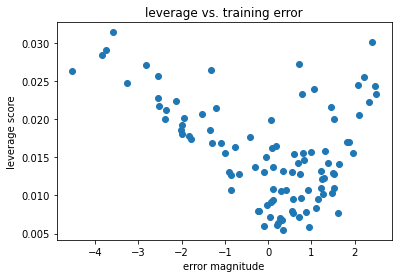

In [ ]:
plt.scatter(e_ti,train_levs)
plt.xlabel('error magnitude')
plt.ylabel('leverage score')
plt.title('leverage vs. training error');

In [ ]:
#DEPRECATED
#Don't use complemented lev weights
#comp = 1- train_levs
#lev_wts = comp/sum(comp)
#plt.scatter(e_ti,lev_wts);

In [ ]:
#DEPRECATED
#Don't use complemented lev weights
#compval = 1 - val_levs
#val_lev_wts = compval/sum(compval)
#plt.scatter(e_vi,val_lev_wts);

Compute Leverage Based Weights

In [ ]:
#USE THIS ONE for normalized leverage based weights
lev_wts = train_levs/sum(train_levs)
val_lev_wts = val_levs/sum(val_levs)

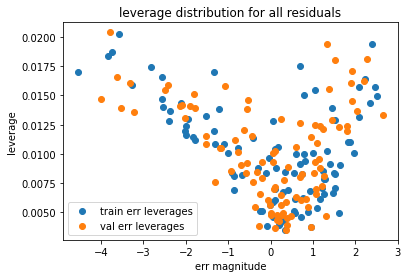

In [ ]:
plt.scatter(e_ti, lev_wts,label = 'train err leverages');
plt.scatter(e_vi,val_lev_wts,label = 'val err leverages')
plt.xlabel('err magnitude')
plt.ylabel('leverage')
plt.title('leverage distribution for all residuals')
plt.legend()
plt.show();

In [ ]:
#declare leverage Weighted Sample Average model
N = len(e_ti) #minus 1 outliers
m4 = ConcreteModel()
m4.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m4.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m4.yA = Var(m4.IDX,domain=NonNegativeReals)
m4.yB = Var(m4.IDX,domain=NonNegativeReals)

#declare objective
m4.OBJ = Objective(expr= -0.1*m4.x[1]-0.5*m4.x[2]+(sum(lev_wts[i-1]*(3*m4.yA[i]+5*m4.yB[i]) for i in m4.IDX)),sense=maximize)

#declare constraints
m4.Constraint1 = Constraint(expr=m4.x[1]+m4.x[2]<=200)
m4.Constraint2 = Constraint(expr=m4.x[1]-0.5*m4.x[2]>=0)

def c3_rule(m,i):
    return m4.yA[i]<=8
m4.Constraint3 = Constraint(m4.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m4.yB[i] <=12
m4.Constraint4 = Constraint(m4.IDX,rule=c4_rule)

def c5_rule(m,i):
    return (3*m4.yA[i]+2*m4.yB[i]) <=36
m4.Constraint5 = Constraint(m4.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(EAE_ti,p=norm_wts)
#    return -B1*m4.x[1] - B2*m4.x[2]+m4.yA[i]+m4.yB[i] <= np.random.choice(B0+e_ti,p=lev_wts) #with wts
     return -B1*m4.x[1] - B2*m4.x[2]+(m4.yA[i]+m4.yB[i]) <= np.random.choice(B0+e_ti) #without wts
m4.Constraint6 = Constraint(m4.IDX, rule=c6_rule)

#solve the SLP with SAA model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m4)

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.1635220682643, 'Upper bound': 40.1635220682643, 'Number of objectives': 1, 'Number of constraints': 399, 'Number of variables': 201, 'Number of nonzeros': 797, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.02196192741394043}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
lev_x1 = m4.x.extract_values()[1]
lev_x2 = m4.x.extract_values()[2]
print('leverage_weighted SAA optimal x1:', m4.x.extract_values()[1])
print('leverage_weighted SAA optimal x2:', m4.x.extract_values()[2])
print('leverage_weighted SAA Obj.', m4.OBJ.expr())

leverage_weighted SAA optimal x1: 182.787822678323
leverage_weighted SAA optimal x2: 17.2121773216769
leverage_weighted SAA Obj. 40.1635220682643


In [ ]:
x1 = lev_x1
x2 = lev_x2
valObjs = []
M = 200 #use 500 or 1000 for point estimate
for reps in range(0,M):
  val_err = np.random.choice(e_vi,p=lev_wts) #do I need to put val_wts on the other validations? default p= uniform draws
#  val_err = np.random.choice(e_vi)
#  val_err =np.random.choice(e_vi, p = val_lev_wts)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/np.sqrt(M)
print('leverage_weighted SLP model predicted objective', m4.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))
#print('mean val ojb', ObjBar)

leverage_weighted SLP model predicted objective 40.1635220682643
Model Validation Sample Average Estimate (95% CI): (39.21136089102851, 40.47597479249159)


In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(lev_x1,lev_x2,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(lev_x1,lev_x2,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())

hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
lev_generr = sum(temp)*(2/len(hts))
print('Leverage Weighted Generalization Error: ',lev_generr)

Leverage Weighted Generalization Error:  -1.4632075607028487


In [ ]:
print('deterministic Generalization Error: ',det_generr)
print('EAE/SAA Generalization Error: ',SAA_generr)
print('EAE/WSAA (Inverse) Generalization Error: ',WSAA_generr)
print('EAE/WSAA (Leverage) Generalization Error: ',lev_generr)

deterministic Generalization Error:  -0.06341372585644191
EAE/SAA Generalization Error:  -1.4594761064117636
EAE/WSAA (Inverse) Generalization Error:  -1.3865086884848896
EAE/WSAA (Leverage) Generalization Error:  -1.4632075607028487


# Extension 3
WSAA with preliminary non-parametric Clustering on weights.

In [ ]:
from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters = 8, random_state = 1).fit(X_train)
#kmeans.labels_

*Non-parametric partitioning*

Use elbow graph to determine optimal number of centroids
by the inflection heuristic

In [ ]:
#create 2d matrix for clustering
#Z = np.concatenate((train_hats[:,np.newaxis],e_ti[:,np.newaxis]),axis=1) #use the yhats as the x-axis
Z = np.concatenate((abs(e_ti[:,np.newaxis]),e_ti[:,np.newaxis]),axis=1) #use abs err as the x-axis
#column 1 is the yhats from training, column 2 is the training errors

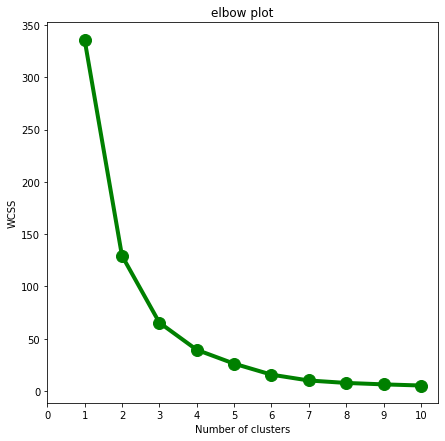

optimal clusters is the inflection point at 3 or 4


In [ ]:
WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(Z)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'green')
plt.xticks(np.arange(11))
plt.title('elbow plot')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
print('optimal clusters is the inflection point at 3 or 4')

In [ ]:
#Per the elbow plot, we choose to use 4 clusters for our training errors as 4 minimizes WCSS (within cluster sum of squares)
#model = KMeans(n_clusters = 4, init = 'k-means++',max_iter = 300,n_init = 10, random_state = 1)
#y_clusters = model.fit_predict(Z)

In [ ]:
#perform clustering
e_km = KMeans(n_clusters = 4, random_state = 1).fit(Z)
#e_km.labels_

In [ ]:
#e_km.cluster_centers_

In [ ]:
Z2 = np.append(Z,e_km.labels_.reshape(len(e_km.labels_),1),axis=1)

In [ ]:
#Z.shape
#e_km.labels_.reshape(99,1)
Z2 = pd.DataFrame(Z2,columns=['yhat','e_ti','bin'])

In [ ]:
Z2.head()

,yhat,e_ti,bin
0,3.751482,-3.751482,1.0
1,1.987583,-1.987583,3.0
2,2.462768,2.462768,2.0
3,0.319569,0.319569,0.0
4,3.587473,-3.587473,1.0


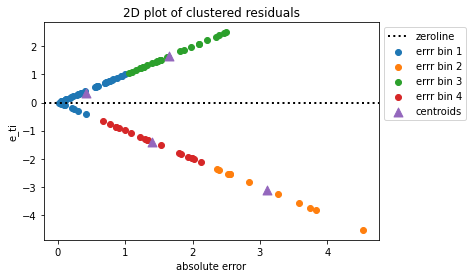

In [ ]:
#visualize clustering
u_labels = np.unique(e_km.labels_)
for i in u_labels:
  plt.scatter(Z2[Z2.bin==i].iloc[:,0],Z2[Z2.bin==i].iloc[:,1],label = 'errr bin %i' %(i+1))
plt.scatter(e_km.cluster_centers_[:,0],e_km.cluster_centers_[:,1],marker = '^',s =80,label = 'centroids')
#plt.xlabel('yhats')
plt.xlabel('absolute error')
plt.ylabel('e_ti')
plt.axhline(y=0,label='zeroline',color='k',linewidth='2',linestyle=':')
plt.title('2D plot of clustered residuals')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
#append y-value sales first for heights
Z3T = np.append(X_train,y_train.reshape(len(y_train),1),axis=1)

In [ ]:
#append error classes
Z3T = np.append(Z3T, e_km.labels_.reshape(len(e_km.labels_),1),axis=1)

In [ ]:
Z3T = pd.DataFrame(Z3T,columns = ['TV','Radio','Sales','bin'])

In [ ]:
Z3T.head()

,TV,Radio,Sales,bin
0,16.9,43.7,8.7,1.0
1,237.4,5.1,12.5,3.0
2,28.6,1.5,7.3,2.0
3,197.6,23.3,16.6,0.0
4,17.2,45.9,9.3,1.0


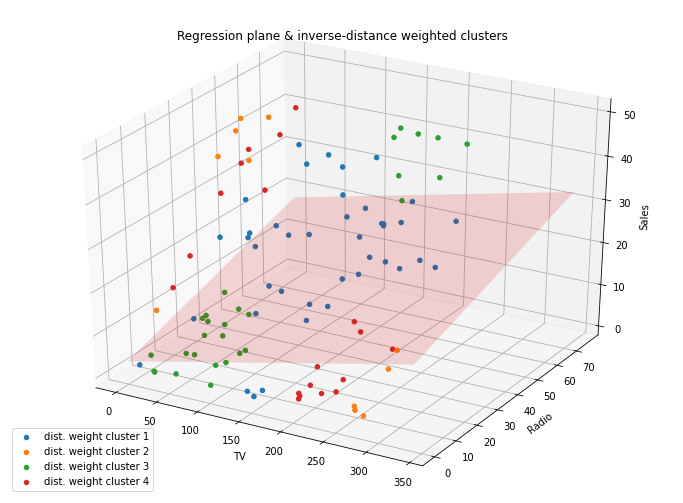

In [ ]:
#visualize clustering result on 3dplane
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111,projection='3d')

#ax.scatter(X_train[:,0],X_train[:,1],y_train,c='b',marker='.',alpha = 0.5)
u_labels = np.unique(e_km.labels_)
for i in u_labels:
  ax.scatter(Z3T[Z3T.bin==i].iloc[:,0],Z3T[Z3T.bin==i].iloc[:,1],Z3T[Z3T.bin==i].iloc[:,1],\
             label = 'dist. weight cluster %i' %(i+1),alpha=1)
ax.legend(loc='lower left')
#plt.scatter(e_km.cluster_centers_[:,0],e_km.cluster_centers_[:,1],marker = '^',s =80)

x_surf = np.arange(0,350,20)
y_surf = np.arange(0,80,4)
xx,yy = np.meshgrid(x_surf,y_surf)
exog = pd.core.frame.DataFrame({'TV':xx.ravel(),'Radio':yy.ravel()})
out = reg1.predict(exog)
ax.plot_surface(xx, yy, np.asarray(out).reshape(xx.shape), rstride=1,cstride=1,color='r',alpha=0.15)

ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
ax.set_title('Regression plane & inverse-distance weighted clusters')
plt.show();

In [ ]:
#Using this non-parametric clustering of the training residuals, we can perform an inverse weighting by assigning each
#error class the weight associated with its avg error centroid from the 2d residual plot.

# the theshold given by p/N where p is the sum of the elements of the main diagonal of the projection matrix P 
# (a sum which should equal the total number of predictor variables) and N is the total number of observations (# of rows of (P))
# the threshold leverage represents an idealized regression plane wherein every point has the same leverage amount
# We can use threshold based weighting as those points which exceed the leverage can be up-weighted while those points with leverage values
# below the threshold can be downweighted or zeroed out.

Apply the inverse-distance weighting based on each cluster's centroid distance.

In [ ]:
err_points = []
for i in range(e_km.cluster_centers_.shape[0]):
  print('error coord for centroid %i' %i,e_km.cluster_centers_[i][1])
  err_points.append(abs(e_km.cluster_centers_[i][1]))
print(err_points)

error coord for centroid 0 0.35323772433590295
error coord for centroid 1 -3.1106233700024517
error coord for centroid 2 1.6538901070501384
error coord for centroid 3 -1.3986743486920497
[0.35323772433590295, 3.1106233700024517, 1.6538901070501384, 1.3986743486920497]


In [ ]:
#get count of number of points in each cluster
bin, binsize = np.unique(e_km.labels_,return_counts=True)
print(bin)
print(binsize)

[0 1 2 3]
[41 11 28 19]


In [ ]:
#normalize the error points, and complement them to get the inverse weight
#complementation
cent_wts = (sum(err_points)-err_points)/sum(err_points)
print(cent_wts)
#normalization
norm_cents = cent_wts/sum(cent_wts)
print(norm_cents)
#print('cent_wts total: ',sum(cent_wts))
print('norm_cents:', sum(norm_cents))
#divide each normalized weight by the number of points in each bin so we have lots of mini uniform distributions:
bin_normed_wts = norm_cents/binsize
print('bin_normed_wts',bin_normed_wts)

[0.94579272 0.52264883 0.74619673 0.78536172]
[0.31526424 0.17421628 0.24873224 0.26178724]
norm_cents: 1.0
bin_normed_wts [0.00768937 0.01583784 0.00888329 0.01377828]


In [ ]:
#assign cent_wts to each point by creating an array repeating the cent_wts values in correct sequence as e_ti by bin
#for i in range(len(e_km.labels_)):
#clstwts = [norm_cents[i] for i in range(len(e_km.labels_)) if i==e_km.labels_[i]]

In [ ]:
ctr_wts =[]
for i in e_km.labels_:
  #if i == e_km.labels[i]:
  ctr_wts.append(bin_normed_wts[i])

In [ ]:
print(ctr_wts[:10])
print(len(ctr_wts))
print('ctr_wts total:',sum(ctr_wts))

[0.015837843289371645, 0.013778275851732798, 0.008883294416219859, 0.007689371682434944, 0.015837843289371645, 0.007689371682434944, 0.007689371682434944, 0.013778275851732798, 0.007689371682434944, 0.007689371682434944]
99
ctr_wts total: 1.0000000000000002


#### Solve the new model with inverse-distance clusters

In [ ]:
#declare Weighted Sample Average model (Distance-based inverse weightings with Cluster Centroid Weights)
N = len(e_ti) #minus 1 outliers
m5 = ConcreteModel()
m5.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m5.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m5.yA = Var(m5.IDX,domain=NonNegativeReals)
m5.yB = Var(m5.IDX,domain=NonNegativeReals)

#declare objective
m5.OBJ = Objective(expr= -0.1*m5.x[1]-0.5*m5.x[2]+(sum(ctr_wts[i-1]*(3*m5.yA[i]+5*m5.yB[i]) for i in m5.IDX)),sense=maximize)

#declare constraints
m5.Constraint1 = Constraint(expr=m5.x[1]+m5.x[2]<=200)
m5.Constraint2 = Constraint(expr=m5.x[1]-0.5*m5.x[2]>=0)

def c3_rule(m,i):
    return m5.yA[i]<=8
m5.Constraint3 = Constraint(m5.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m5.yB[i] <=12
m5.Constraint4 = Constraint(m5.IDX,rule=c4_rule)

def c5_rule(m,i):
    return (3*m5.yA[i]+2*m5.yB[i]) <=36
m5.Constraint5 = Constraint(m5.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= EAE_ti[i-1] #EAE_ti = B0 + e_ti (array of training errors)
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(EAE_ti,p=norm_wts)
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(B0+e_ti,p=ctr_wts) #with wts
     return -B1*m5.x[1] - B2*m5.x[2]+(m5.yA[i]+m5.yB[i]) <= np.random.choice(B0+e_ti) #without wts
m5.Constraint6 = Constraint(m5.IDX, rule=c6_rule)

#solve the SLP with SAA model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m5)

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.0553615498505, 'Upper bound': 40.0553615498505, 'Number of objectives': 1, 'Number of constraints': 399, 'Number of variables': 201, 'Number of nonzeros': 797, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.02295398712158203}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
clst_x1 = m5.x.extract_values()[1]
clst_x2 = m5.x.extract_values()[2]
print('inverse_weighted clusters optimal x1:', m5.x.extract_values()[1])
print('inverse_weighted clusters optimal x2:', m5.x.extract_values()[2])
print('inverse_weighted clusters Obj.', m5.OBJ.expr())

inverse_weighted clusters optimal x1: 182.422888877802
inverse_weighted clusters optimal x2: 17.5771111221982
inverse_weighted clusters Obj. 40.055361549850424


In [ ]:
x1 = clst_x1
x2 = clst_x2
valObjs = []
M = 200 #use 500 or 1000 for point estimate
for reps in range(0,M):
  val_err = np.random.choice(e_vi) #do I need to put val_wts on the other validations? default p= uniform draws
#  val_err = np.random.choice(e_vi)
#  val_err =np.random.choice(e_vi, p = val_lev_wts)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/np.sqrt(M)
print('inverse_weight clusters SLP model predicted objective', m5.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))
#print('mean val ojb', ObjBar)

inverse_weight clusters SLP model predicted objective 40.055361549850424
Model Validation Sample Average Estimate (95% CI): (39.54608665447223, 40.820172701044676)


In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(clst_x1,clst_x2,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(clst_x1,clst_x2,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())

hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
clust_inv_generr = sum(temp)*(2/len(hts))
print('EAE/WSAA (clustered inverse) Generalization Error: ',clust_inv_generr)

EAE/WSAA (clustered inverse) Generalization Error:  -1.4013763274250455


In [ ]:
print('deterministic Generalization Error: ',det_generr)
print('EAE/SAA Generalization Error: ',SAA_generr)
print('EAE/WSAA (Inverse) Generalization Error: ',WSAA_generr)
print('EAE/WSAA (clustered inverse) Generalization Error: ',clust_inv_generr)
print('EAE/WSAA (Leverage) Generalization Error: ',lev_generr)

deterministic Generalization Error:  -0.06341372585644191
EAE/SAA Generalization Error:  -1.4594761064117636
EAE/WSAA (Inverse) Generalization Error:  -1.3865086884848896
EAE/WSAA (clustered inverse) Generalization Error:  -1.4013763274250455
EAE/WSAA (Leverage) Generalization Error:  -1.4632075607028487


### Leverage clustering:
1. run elbow heuristic & clustering on both R2 spaces and visualize their R3 result
2. choose the more distinct of the two to use and find MPO

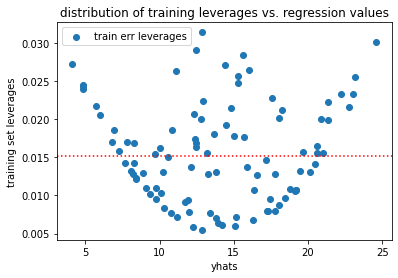

In [ ]:
plt.scatter(train_hats,train_levs,label='train err leverages')
plt.xlabel('yhats')
plt.ylabel('training set leverages')
plt.axhline(y = thresh, color = 'r',linestyle=':')
plt.title('distribution of training leverages vs. regression values')
plt.legend()
plt.show();

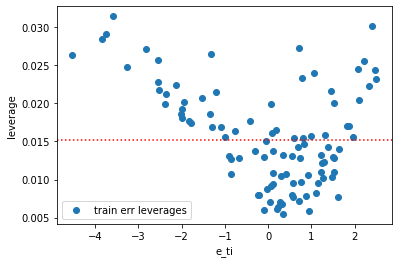

In [ ]:
plt.scatter(e_ti, train_levs,label = 'train err leverages');
#plt.scatter(e_vi,val_lev_wts,label = 'val err leverages')
plt.axhline(y = thresh, color = 'r',linestyle=':')
plt.xlabel('e_ti')
plt.ylabel('leverage')
plt.legend()
plt.show();

In [ ]:
# The thresh value computed as p/N represents an ideal regression wherein every point has equal leverage
# such that we might expect all points to lie exactly on our manifold with no observation having any outsized 
# effect on its estimate
# p = number of regressors (in our case it is 3 since 2 vars + beta_0), N = total number of obs.

In [ ]:
#create 2d J matrix for clustering
#determine the appropriate x-dimension space to do the leverage clustering. 

#J = np.concatenate((e_ti[:,np.newaxis],train_levs[:,np.newaxis]),axis=1) #Uses error magnitudes as x-dimension
#J = np.concatenate((train_hats[:,np.newaxis],train_levs[:,np.newaxis]),axis=1) #alternate clustering uses yhats as x-dimension
J = np.concatenate((abs(e_ti[:,np.newaxis]),train_levs[:,np.newaxis]),axis=1)# uses absolute err as x-dimension as in inverse-weighting

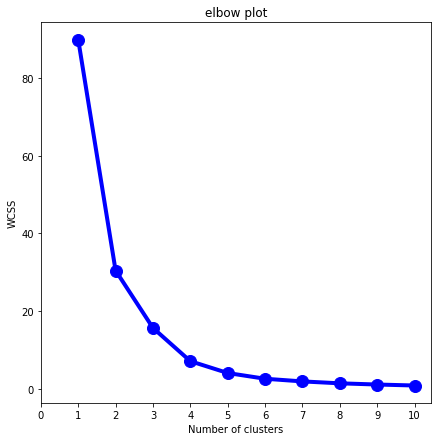

optimal clusters is the inflection point at 3 or 4


In [ ]:
WCSS = []
for i in range(1,11):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(J) #use J or Q
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,11),WCSS, linewidth=4, markersize=12,marker='o',color = 'blue')
plt.xticks(np.arange(11))
plt.title('elbow plot')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()
print('optimal clusters is the inflection point at 3 or 4')

In [ ]:
#perform clustering with optimal number of clusters from elbow plot heuristic
lev_km = KMeans(n_clusters = 4, random_state = 1).fit(J)

In [ ]:
J2 = np.append(J,lev_km.labels_.reshape(len(lev_km.labels_),1),axis=1)

In [ ]:
#J2 = pd.DataFrame(J2,columns=['yhat','lev_ti','bin'])
J2 = pd.DataFrame(J2,columns=['e_ti','lev_ti','bin'])

In [ ]:
J2.head()

,e_ti,lev_ti,bin
0,3.751482,0.029045,2.0
1,1.987583,0.019232,1.0
2,2.462768,0.024394,1.0
3,0.319569,0.006747,0.0
4,3.587473,0.031418,2.0


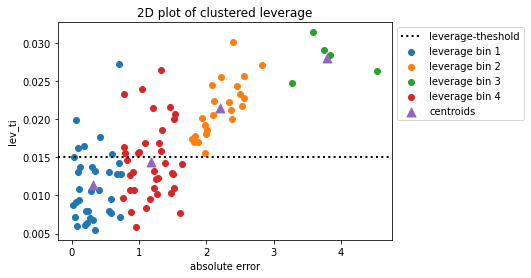

In [ ]:
u_labels = np.unique(lev_km.labels_)
for i in u_labels:
  plt.scatter(J2[J2.bin==i].iloc[:,0],J2[J2.bin==i].iloc[:,1],label = 'leverage bin %i' %(i+1))
plt.scatter(lev_km.cluster_centers_[:,0],lev_km.cluster_centers_[:,1],marker = '^',s =80,label = 'centroids')
#plt.xlabel('yhats')
#plt.xlabel('e_ti')
plt.ylabel('lev_ti')
plt.xlabel('absolute error')
plt.axhline(y=.015,label='leverage-theshold',color='k',linewidth='2',linestyle=':')
plt.title('2D plot of clustered leverage')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [ ]:
#append y-value sales first for heights
J3T = np.append(X_train,y_train.reshape(len(y_train),1),axis=1)

In [ ]:
#append error bin classes
J3T = np.append(J3T, lev_km.labels_.reshape(len(lev_km.labels_),1),axis=1)

In [ ]:
J3T = pd.DataFrame(J3T,columns = ['TV','Radio','Sales','bin'])

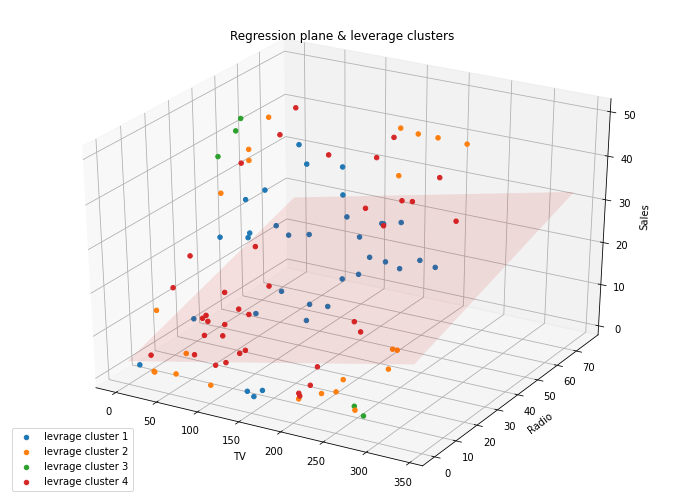

In [ ]:
#3Dvisualization of leverage clusters
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111,projection='3d')

#ax.scatter(X_train[:,0],X_train[:,1],y_train,c='b',marker='.',alpha = 0.5)
u_labels = np.unique(lev_km.labels_)
for i in u_labels:
  ax.scatter(J3T[J3T.bin==i].iloc[:,0],J3T[J3T.bin==i].iloc[:,1],J3T[J3T.bin==i].iloc[:,1],label = 'levrage cluster %i' %(i+1),alpha=1)
ax.legend(loc='lower left')
#plt.scatter(e_km.cluster_centers_[:,0],e_km.cluster_centers_[:,1],marker = '^',s =80)

x_surf = np.arange(0,350,20)
y_surf = np.arange(0,80,4)
xx,yy = np.meshgrid(x_surf,y_surf)
exog = pd.core.frame.DataFrame({'TV':xx.ravel(),'Radio':yy.ravel()})
out = reg1.predict(exog)
ax.plot_surface(xx, yy, np.asarray(out).reshape(xx.shape), rstride=1,cstride=1,color='r',alpha=0.1)

ax.set_xlabel('TV')
ax.set_ylabel('Radio')
ax.set_zlabel('Sales')
ax.set_title('Regression plane & leverage clusters')
plt.show();

Apply leverage cluster based weightings

In [ ]:
err_points = []
for i in range(lev_km.cluster_centers_.shape[0]):
  print('error coord for centroid %i' %i,lev_km.cluster_centers_[i][1])
  err_points.append(abs(lev_km.cluster_centers_[i][1]))
print(err_points)

error coord for centroid 0 0.011387577659659894
error coord for centroid 1 0.021415648882053512
error coord for centroid 2 0.028008527802661838
error coord for centroid 3 0.014432496697921472
[0.011387577659659894, 0.021415648882053512, 0.028008527802661838, 0.014432496697921472]


In [ ]:
#get count of number of points in each cluster
bin, binsize = np.unique(lev_km.labels_,return_counts=True)
print(bin)
print(binsize)

[0 1 2 3]
[34 23  5 37]


In [ ]:
#normalize the error points, and complement them to get the inverse weight
#complementation
cent_wts = (sum(err_points)-err_points)/sum(err_points)
print(cent_wts)
#normalization
norm_cents = cent_wts/sum(cent_wts)
print(norm_cents)
#print('cent_wts total: ',sum(cent_wts))
print('norm_cents:', sum(norm_cents))
#divide each normalized weight by the number of points in each bin so we have lots of mini uniform distributions:
bin_normed_wts = norm_cents/binsize
print('bin_normed_wts',bin_normed_wts)

[0.8486585  0.71538492 0.62776521 0.80819137]
[0.28288617 0.23846164 0.20925507 0.26939712]
norm_cents: 0.9999999999999998
bin_normed_wts [0.00832018 0.0103679  0.04185101 0.007281  ]


In [ ]:
#assign cent_wts to each point by creating an array repeating the cent_wts values in correct sequence as e_ti by bin
#for i in range(len(e_km.labels_)):
#clstwts = [norm_cents[i] for i in range(len(e_km.labels_)) if i==e_km.labels_[i]]

In [ ]:
ctr_wts =[]
for i in lev_km.labels_:
  #if i == e_km.labels[i]:
  ctr_wts.append(bin_normed_wts[i])

In [ ]:
print(ctr_wts[:10])
print(len(ctr_wts)) #should be the same as length as training set
#confirm that the new cluster weights form a proper probability distribution
print('ctr_wts total:',sum(ctr_wts))

[0.04185101416193907, 0.010367897323484605, 0.010367897323484605, 0.008320181393325521, 0.04185101416193907, 0.008320181393325521, 0.008320181393325521, 0.010367897323484605, 0.008320181393325521, 0.008320181393325521]
99
ctr_wts total: 1.0000000000000009


### Solve new Model 6
Using leverage-clusters

In [ ]:
#declare Weighted Sample Average model (Distance-based inverse weightings with Cluster Centroid Weights)
N = len(e_ti) #minus 1 outliers
m6 = ConcreteModel()
m6.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m6.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m6.yA = Var(m6.IDX,domain=NonNegativeReals)
m6.yB = Var(m6.IDX,domain=NonNegativeReals)

#declare objective
m6.OBJ = Objective(expr= -0.1*m6.x[1]-0.5*m6.x[2]+(sum(ctr_wts[i-1]*(3*m6.yA[i]+5*m6.yB[i]) for i in m6.IDX)),sense=maximize)

#declare constraints
m6.Constraint1 = Constraint(expr=m6.x[1]+m6.x[2]<=200)
m6.Constraint2 = Constraint(expr=m6.x[1]-0.5*m6.x[2]>=0)

def c3_rule(m,i):
    return m6.yA[i]<=8
m6.Constraint3 = Constraint(m6.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m6.yB[i] <=12
m6.Constraint4 = Constraint(m6.IDX,rule=c4_rule)

def c5_rule(m,i):
    return (3*m6.yA[i]+2*m6.yB[i]) <=36
m6.Constraint5 = Constraint(m6.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    return -B1*m.x[1] - B2*m.x[2]+m.yA[i]+m.yB[i] <= EAE_ti[i-1] #EAE_ti = B0 + e_ti (array of training errors)
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(EAE_ti,p=norm_wts)
#    return -B1*m3.x[1] - B2*m3.x[2]+m3.yA[i]+m3.yB[i] <= np.random.choice(B0+e_ti,p=ctr_wts) #with wts
     return -B1*m6.x[1] - B2*m6.x[2]+(m6.yA[i]+m6.yB[i]) <= np.random.choice(B0+e_ti) #without wts
m6.Constraint6 = Constraint(m6.IDX, rule=c6_rule)

#solve the SLP with WSAA-clustered leverage model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m6)

{'Problem': [{'Name': 'unknown', 'Lower bound': 40.7479733479036, 'Upper bound': 40.7479733479036, 'Number of objectives': 1, 'Number of constraints': 399, 'Number of variables': 201, 'Number of nonzeros': 797, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.022979736328125}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
lev_clst_x1 = m6.x.extract_values()[1]
lev_clst_x2 = m6.x.extract_values()[2]
print('leverage_weighted SAA optimal x1:', m6.x.extract_values()[1])
print('leverage_weighted SAA optimal x2:', m6.x.extract_values()[2])
print('leverage_weighted SAA Obj.', m6.OBJ.expr())

leverage_weighted SAA optimal x1: 183.35506389571
leverage_weighted SAA optimal x2: 16.6449361042897
leverage_weighted SAA Obj. 40.74797334790366


In [ ]:
x1 = lev_clst_x1
x2 = lev_clst_x2
valObjs = []
M = 200 #use 500 or 1000 for point estimate
for reps in range(0,M):
#  val_err = np.random.choice(e_vi,p=lev_wts) #do I need to put val_wts on the other validations? default p= uniform draws
  val_err = np.random.choice(e_vi)
#  val_err =np.random.choice(e_vi, p = val_lev_wts)
  valmod = SLP_val_solve(x1,x2,val_err)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/np.sqrt(M)
print('clustered_inverse_weight SLP model predicted objective', m6.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))
#print('mean val ojb', ObjBar)

clustered_inverse_weight SLP model predicted objective 40.74797334790366
Model Validation Sample Average Estimate (95% CI): (39.866231913529404, 41.02791879060614)


In [ ]:
hts,hvs = [],[]
for i in range(0,len(e_ti)):
  ht = hSolve(lev_clst_x1,lev_clst_x2,B0,B1,B2,e_ti[i])
  hts.append(ht.OBJ())
  hv = hSolve(lev_clst_x1,lev_clst_x2,B0,B1,B2,e_vi[i])
  hvs.append(hv.OBJ())
hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
clust_lev_generr = sum(temp)*(2/len(hts))
print('EAE/WSAA (clustered leverage) Generalization Error: ',clust_lev_generr)

EAE/WSAA (clustered leverage) Generalization Error:  -1.4539489843458988


In [ ]:
print('deterministic Generalization Error: ',det_generr)
print('EAE/SAA Generalization Error: ',SAA_generr)
print('EAE/WSAA (Inverse) Generalization Error: ',WSAA_generr)
print('EAE/WSAA (clustered inverse) Generalization Error: ',clust_inv_generr)
print('EAE/WSAA (Leverage) Generalization Error: ',lev_generr)
print('EAE/WSAA (clustered leverage) Generalization Error: ',clust_lev_generr)

deterministic Generalization Error:  -0.06341372585644191
EAE/SAA Generalization Error:  -1.4594761064117636
EAE/WSAA (Inverse) Generalization Error:  -1.3865086884848896
EAE/WSAA (clustered inverse) Generalization Error:  -1.4013763274250455
EAE/WSAA (Leverage) Generalization Error:  -1.4632075607028487
EAE/WSAA (clustered leverage) Generalization Error:  -1.4539489843458988


# Multivariate Multiple Regression

In this scenario we consider a case where there are 2 dependent variables. In addition to the doors product, we imagine that Wyndor also has total sales of another widgets product that they would like to optimize. To simulate this scenario we generate an additional sales vector that is negatively correlated with the original sales data.

In [ ]:
#Generate Synthetic Data
data2 = data.copy()
#data2['Sales2'] = np.asarray(data['Sales'])+np.random.normal(data.Sales.mean(),data.Sales.std(),size=len(data))
#data2['Sales2'] = np.asarray(data['Sales'])+np.random.normal(data.Sales.min(),data.Sales.std(),size=len(data))

In [ ]:
salesVar = data.Sales.std()**2
salesMu = data.Sales.mean()
Muvec = np.array([salesMu,salesMu])
fakecov = np.array([[salesVar,-22.0],\
                   [-22.0,salesVar]])
t = np.asarray(np.random.multivariate_normal(Muvec,fakecov,size=len(data.Sales)))

In [ ]:
#data2['Sales'] = t[:,0]
data2['Sales2'] = t[:,1]

In [ ]:
data2.head()

,TV,Radio,Newspaper,Sales,Sales2
1,230.1,37.8,69.2,22.1,16.081384
2,44.5,39.3,45.1,10.4,11.286159
3,17.2,45.9,69.3,9.3,22.861605
4,151.5,41.3,58.5,18.5,7.371872
5,180.8,10.8,58.4,12.9,9.264822


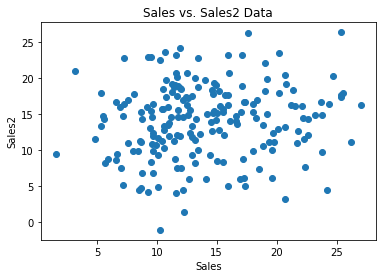

In [ ]:
plt.scatter(data2.Sales,data2.Sales2)
plt.xlabel('Sales')
plt.ylabel('Sales2')
plt.title('Sales vs. Sales2 Data');

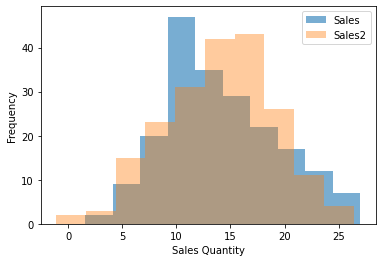

In [ ]:
plt.hist(data2.Sales,label='Sales',alpha=0.6)
plt.hist(data2.Sales2,label='Sales2',alpha=0.4)
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.legend()
plt.show();

In [ ]:
;#split data in half to train and test aka validation sets
X2 = data2.iloc[:,:2] #x1, x2
y2 = data2.iloc[:,3:] # sales and sales2 as omega and omega 2
#split data in half so that N = 100 for train and test.
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.5,random_state=1) 
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.5)

In [ ]:
#Fit multivariate regression using statsmodels
from statsmodels.multivariate import manova

In [ ]:
#df_multi =pd.concat([X2_train,y2_train],axis=1,ignore_index=False)
#X2_train,
#type(y2_train)
#df_multi
X2_train.head()

,TV,Radio
76,16.9,43.7
22,237.4,5.1
92,28.6,1.5
153,197.6,23.3
3,17.2,45.9


In [ ]:
#np.conX2_train.shape
X2_exog = np.concatenate((np.ones(len(X2_train))[:,np.newaxis],np.asarray(X2_train)),axis=1)

In [ ]:
#ones = pd.DataFrame(np.ones(len(X2_train)))
#X2_exog = pd.concat([ones,X2_train],axis=1,ignore_index=True)
X2_exog[:5]

array([[  1. ,  16.9,  43.7],
       [  1. , 237.4,   5.1],
       [  1. ,  28.6,   1.5],
       [  1. , 197.6,  23.3],
       [  1. ,  17.2,  45.9]])

In [ ]:
#maov = manova.MANOVA.from_formula('TV + Radio ~ Sales',data=df_multi)
mano = manova.MANOVA(exog=X2_exog,endog=np.asarray(y2_train),hasconst=True)
print(mano.mv_test())

                  Multivariate linear model
                                                             
-------------------------------------------------------------
            x0           Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.3403 2.0000 96.0000 93.0615 0.0000
          Pillai's trace 0.6597 2.0000 96.0000 93.0615 0.0000
  Hotelling-Lawley trace 1.9388 2.0000 96.0000 93.0615 0.0000
     Roy's greatest root 1.9388 2.0000 96.0000 93.0615 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
           x1           Value  Num DF  Den DF F Value  Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.1812 2.0000 96.0000 216.8351 0.0000
         Pillai's trace 0.8188 2.0000 96.0000 216.8351 0.0000
 Hotelling-Lawley trace 4.

In [ ]:
#Fit multivariate linear regression using sklearn
reg2 = LinearRegression().fit(X2_train,y2_train)

In [ ]:
betas = reg2.coef_ #row 1 is regression model 1 betas, row 2 is regression model 2 betas

In [ ]:
intcpts = reg2.intercept_ #first element is regression model 1 b0, second element is regression model 2's b0

In [ ]:
B0 = intcpts[0]
B1 = betas[0][0]
B2 = betas[0][1]

B0_2 = intcpts[1]
B1_2 = betas[1][0]
B2_2 = betas[1][1]

In [ ]:
print('model 1 coefficients B0,B1,B2:',[B0,B1,B2]) #yA+yB sales
print('model 2 coefficients B0, B1, B2:',[B0_2,B1_2,B2_2]) #zA+zB sales

model 1 coefficients B0,B1,B2: [3.1248579288521476, 0.044751553149986065, 0.18525853949540994]
model 2 coefficients B0, B1, B2: [13.15724891155968, 0.0020110648483176036, 0.03905009535884686]


In [ ]:
y2_train.shape

(100, 2)

In [ ]:
#train errs
multe_ti = np.asarray(y2_train - reg2.predict(X2_train))
m1e_ti, m2e_ti = multe_ti[:,0], multe_ti[:,1]

In [ ]:
#val errs
multe_vi = np.asarray(y2_test - reg2.predict(X2_test))
m1e_vi, m2e_vi = multe_vi[:,0], multe_vi[:,1]

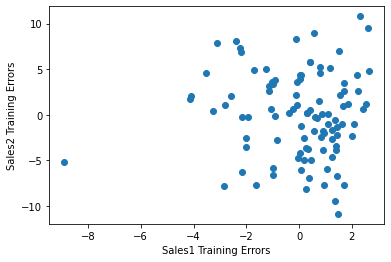

correlation_coef -0.018003988830644024
covariance -0.15308657607444073
covariance matrix: 
 [[ 3.32772679 -0.15308658]
 [-0.15308658 21.72646584]]


In [ ]:
plt.scatter(m1e_ti, m2e_ti)
plt.xlabel('Sales1 Training Errors')
plt.ylabel('Sales2 Training Errors')
plt.show();
cov = np.cov(m1e_ti,m2e_ti)
print('correlation_coef', np.corrcoef(m1e_ti,m2e_ti)[0][1])
print('covariance', np.cov(m1e_ti,m2e_ti)[0][1])
print('covariance matrix: \n', np.cov(m1e_ti,m2e_ti))

In [ ]:
invsig = np.linalg.inv(cov)
invsig

array([[0.30060288, 0.00211807],
       [0.00211807, 0.04604174]])

In [ ]:
mu1 = np.mean(m1e_ti)
mu2 = np.mean(m2e_ti)
sig11 = cov[0][0]
sig12 = cov[0][1]
sig22 = invsig[1][1]
sig21 = cov[1][0]
print('m1e_ti mean', np.mean(m1e_ti))
print('m2e_ti mean', np.mean(m2e_ti))

m1e_ti mean 8.260059303211165e-16
m2e_ti mean 7.549516567451064e-16


In [ ]:
#Use Conditional distribution to create a weighting vector
a = np.random.choice(m1e_ti)
samp = np.random.normal(mu1+sig12*sig22*(a-mu2),sig11-sig12*sig22*sig21)
conmu = mu1+sig12*sig22*(a-mu2)
convar = sig11-sig12*sig22*sig21

In [ ]:
###Use discretization function to discretize the conditional and generate a set of weightings for model2's errors.

In [ ]:
def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def discretizeNormal(mu,sigma, n,res = 1):
    wts = []
    startpt = mu - n//2*sigma
    endpt = mu + n//2*sigma
    leftvals = np.arange(startpt,mu,res*sigma)
    rightvals = np.arange(mu, endpt + res*sigma, res*sigma)
    vals = np.concatenate((leftvals,rightvals))
    zscores = (vals - mu)/sigma
    zmidpts = (zscores[1:]+zscores[:-1])/2
    for i,j in pairwise(zmidpts):
        wts.append(np.diff(norm.cdf((i,j))).item())
    wts.insert(0,norm.cdf(zmidpts[0]))
    wts.insert(len(wts),norm.cdf(zmidpts[0]))
    return (vals,wts)

In [ ]:
condval, condwts = discretizeNormal(conmu,convar,n=10,res=0.1)

In [ ]:
len(X2_train)

100

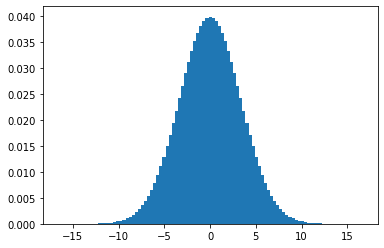

In [ ]:
plt.hist(condval,weights=condwts,bins=99);

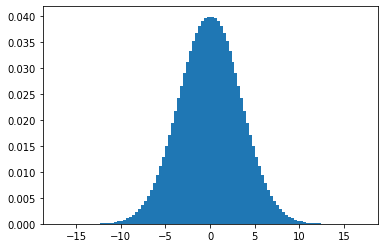

In [ ]:
plt.bar(condval,condwts);

In [ ]:
len(condwts[:-1])

100

Solve Model with Draws from Conditional Distribution

In [ ]:
#draw from conditional distribution of model 2's errors wher a is the value of model 1's error we condition on
#samples = np.random.normal(mu1+sig12*sig22*(a-mu2),abs(sig11 - sig12 *sig22* sig21),size=500)
#pdf, bins = np.histogram(samples,bins = len(X2_train), density = True)

In [ ]:
#plt.hist(samp)
##pdf

In [ ]:
#Compute the conditional distribution of Sales2 Training Errors given Sales1


In [ ]:
#declare model
N = len(y2_train) #minus 1 outliers #N should be = len(EAE_ti)
m7 = ConcreteModel()
m7.IDX = RangeSet(1,N)
#declare variables
def _bounds_rule(m,i):
    return bounds[i-1]
m7.x = Var([1,2],domain = NonNegativeReals,bounds=_bounds_rule)

m7.yA = Var(m7.IDX,domain=NonNegativeReals)
m7.yB = Var(m7.IDX,domain=NonNegativeReals)

m7.zA = Var(m7.IDX, domain=NonNegativeReals)
m7.zB = Var(m7.IDX, domain=NonNegativeReals)

#declare objective
m7.OBJ = Objective(expr= -0.1*m7.x[1]-0.5*m7.x[2]+(1/N)*(sum(3*m7.yA[i]+5*m7.yB[i]+.3*m7.zA[i]+.5*m7.zB[i] for i in m7.IDX)),sense=maximize)

#declare constraints
m7.Constraint1 = Constraint(expr=m7.x[1]+m7.x[2]<=200)
m7.Constraint2 = Constraint(expr=m7.x[1]-0.5*m7.x[2]>=0)

def c3_rule(m,i):
    return m7.yA[i]+m7.zA[i]<=8
m7.Constraint3 = Constraint(m7.IDX,rule=c3_rule)

def c4_rule(m,i):
    return m7.yB[i] +m7.zB[i] <=12
m7.Constraint4 = Constraint(m7.IDX,rule=c4_rule)

def c5_rule(m,i):
    return 3*m7.yA[i]+2*m7.yB[i] + 3*m7.zA[i]+2*m7.zB[i]<=36
m7.Constraint5 = Constraint(m7.IDX,rule=c5_rule)

#np.random.shuffle(EAE_ti) #randomizes the training errors for constraint6

def c6_rule(m,i):
#    np.random.seed(1)
    a = np.random.choice(m1e_ti)
    return -B1*m7.x[1] - B2*m7.x[2]+m7.yA[i]+m7.yB[i] <= B0 + a
m7.Constraint6 = Constraint(m7.IDX, rule=c6_rule)

def c6_ruleb(m,i):
#    np.random.seed(1)
#    a = np.random.choice(m1e_ti)
    conmu = mu1+sig12*sig22*(a-mu2)
    convar = sig11-sig12*sig22*sig21
    condval, condwts = discretizeNormal(conmu,convar,n=10,res=0.1)
#    return -B1_2*m7.x[1] - B2_2*m7.x[2]+m7.zA[i]+m7.zB[i] <= B0_2 + np.random.choice(m2e_ti) #using independence assumption
#    return -B1_2*m7.x[1] - B2_2*m7.x[2]+m7.zA[i]+m7.zB[i] <= B0_2+np.random.normal(mu1+sig12*sig22*(a-mu2),sig11-sig12*sig22*sig21) #m2e_ti conditional dist
    return -B1_2*m7.x[1] - B2_2*m7.x[2]+m7.zA[i]+m7.zB[i] <= B0_2 + np.random.choice(m2e_ti,p=condwts[:-1]) #using discretized conditional distribution
#m7.Constraint6b = Constraint(m7.IDX, rule=c6_ruleb)

#solve the SLP with SAA model
opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
#opt = SolverFactory('cbc')
#opt.solve(m,,tee=True)
opt.solve(m7)

{'Problem': [{'Name': 'unknown', 'Lower bound': 41.2350543607146, 'Upper bound': 41.2350543607146, 'Number of objectives': 1, 'Number of constraints': 403, 'Number of variables': 403, 'Number of nonzeros': 1205, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.02945232391357422}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Using a multivariate multiple regression model, we can incorporate a second regression inside of our LEO model. Moreover, we are able to incorporate information regarding the correlation between the coefficients of each model. In particular, the use of this approach allows us to incorporate knowledge of the correlation between the two model's error such that the second model's error terms can be drawn from the conditional distribution so that the LEO model is effectively solving with errors drawn from the joint distribution between the two.

In [ ]:
#Validation Solve for Multivariate Multiple Regression-LEO
def SLP_val_solve2(x1,x2,val_err1, val_err2):
  mv = ConcreteModel()

  mv.yA = Var(domain=NonNegativeReals,initialize=0)
  mv.yB = Var(domain=NonNegativeReals,initialize=0)
  mv.zA = Var(domain=NonNegativeReals,initialize=0)
  mv.zB = Var(domain=NonNegativeReals,initialize=0)

  #declare objective
  mv.OBJ = Objective(expr= -0.1*x1-0.5*x2+3*mv.yA+5*mv.yB+.3*mv.zA+.5*mv.zB,sense=maximize)

  mv.Constraint3 = Constraint(expr=mv.yA+ mv.zA<=8)

  mv.Constraint4 = Constraint(expr=mv.yB + mv.zB <=12)

  mv.Constraint5 = Constraint(expr=3*mv.yA+ 2*mv.yB + 3*mv.zA+ 2*mv.zB<=36)

  mv.Constraint6 = Constraint(expr= mv.yA + mv.yB<= B0 + val_err1+B1*x1+B2*x2)
  mv.Constraint6b = Constraint(expr= mv.zA+ mv.zB<= B0_2 + val_err2+B1_2*x1+B2_2*x2)

  #solve the SLP with SAA model
  opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
  #opt = SolverFactory('cbc')
  #opt.solve(m,,tee=True)
  opt.solve(mv)
  return mv

In [ ]:
multi_x1 = m7.x.extract_values()[1]
multi_x2 = m7.x.extract_values()[2]
print('multivar SAA optimal x1:', m7.x.extract_values()[1])
print('multivar SAA optimal x2:', m7.x.extract_values()[2])
print('multivar SAA Obj.', m7.OBJ.expr())

multivar SAA optimal x1: 188.534836784598
multivar SAA optimal x2: 11.4651632154016
multivar SAA Obj. 41.235054360714656


In [ ]:
x1 = multi_x1
x2 = multi_x2
valObjs = []
M = 200#use 500 or 1000 for point estimate
for reps in range(0,M):
  val_err1 = np.random.choice(m1e_vi)
  val_err2 = np.random.choice(m2e_vi)
  valmod = SLP_val_solve2(x1,x2,val_err1, val_err2)
  valObjs.append(valmod.OBJ())

ObjBar = np.mean(valObjs)
se = np.std(valObjs)/np.sqrt(len(valObjs))
print('Multivariate SLP model predicted objective', m7.OBJ())
print('Model Validation Sample Average Estimate (95% CI):', (ObjBar - 1.96*se, ObjBar+1.96*se))
#print('mean val ojb', ObjBar)

Multivariate SLP model predicted objective 40.385888335943235
Model Validation Sample Average Estimate (95% CI): (38.424830574178706, 41.29469954649671)


In [ ]:
#Multivar Recourse Solve
def h2Solve(x1,x2,B0,B1,B2,B0_2,B1_2,B2_2,err,errb):
  h2 = ConcreteModel()
  h2.yA = Var(domain=NonNegativeReals,initialize=0)
  h2.yB = Var(domain=NonNegativeReals,initialize=0)
  h2.zA = Var(domain=NonNegativeReals,initialize=0)
  h2.zB = Var(domain=NonNegativeReals,initialize=0)

  h2.OBJ = Objective(expr=3*h2.yA+5*h2.yB+.3*h2.zA+.5*h2.zB,sense=maximize)

  h2.Constraint1 = Constraint(expr = h2.yA+h2.zA <= 8)
  h2.Constraint2 = Constraint(expr = h2.yB +h2.zB <= 12)
  h2.Constraint3 = Constraint(expr = 3*h2.yA + 2*h2.yB+ 3*h2.zA +2*h2.zB<= 36)
  h2.Constraint4 = Constraint(expr = h2.yA + h2.yB <= B0 + B1*x1 + B2*x2 + err)
  h2.Constraint4b = Constraint(expr= h2.zA +h2.zB <=  B0_2 + B1_2*x1+B2_2*x2+errb)
##
  #solve model
  opt = SolverFactory('glpk',executable='/usr/bin/glpsol')
  opt.solve(h2)

  return h2

In [ ]:
hts,hvs = [],[]
for i in range(0,len(m1e_ti)):
  ht = h2Solve(multi_x1,multi_x2,B0,B1,B2,B0_2,B1_2,B2_2,m1e_ti[i],m2e_ti[i])
  hts.append(ht.OBJ())
  hv = h2Solve(multi_x1,multi_x2,B0,B1,B2,B0_2,B1_2,B2_2,m1e_vi[i],m2e_vi[i])
  hvs.append(hv.OBJ())
hts = np.asarray(hts)
hvs = np.asarray(hvs)
#compute covariances for recourse scalar values and sum them
temp = [(hvs-hvs.mean())[i]*(hts-hts.mean())[i] for i in range(len(hts))]
multiReg_generr = sum(temp)*(2/len(hts))
print('Multivariate Regression LEO Generalization Error: ',multiReg_generr)

Multivariate Regression LEO Generalization Error:  10.650610090146836
